Example: Feature importance and SHAP values
===================================================================

Motivation
----------

As stated in the [example on LIME explainability](../example_lime/), LIME is a *local*
explainability method. This means that LIME focuses on one sample -- or its
locality/vicinity/neighborhood -- at a time and tries to imitate the
true model behaviour around that sample with a simpler model.

On the other hand, SHAP -- short for *SHapley Additive exPlanations* -- is another popular
method for interpretability which can provide both local and global interpretations. It
uses a cooperative game theory approach to estimate the impact of each feature on the prediction.
Local interpretation in SHAP refers to the explanation for a specific prediction made for
an individual instance in your dataset. In addition, global interpretation can be achieved
in a holistic way by analyzing the importance of each feature across the entire dataset.

Lastly, feature importance computation is another widely-used method for global interpretability.
While it may not be applicable to all types of models, most tree-based models—including
decision trees, random forests, and gradient boosting machines—come with built-in mechanisms
for calculating feature importance. This approach ranks the features based on their
contributions to the model, providing an overarching view of what features predominantly
drive the model's decision-making process.

While SHAP and feature importance are typically used in supervised learning scenarios, the key
motivation of better understanding a model's behaviour applies just as well to CATE
estimation. However, in the context of MetaLearners when compared to the traditional supervised setting,
there's a notable challenge. Some MetaLearners, such as the `SLearner`,
`TLearner` and `XLearner`, do not possess a direct
CATE prediction model. Conversely, others like the `RLearner` and
`DRLearner` have a dedicated second stage model which directly estimates the CATE.
Given these varied scenarios, we provide examples for both situations in the subsequent sections.
Therefore, we illustrate how it can be used with the MetaLearners from ``metalearners``.

Background
----------

### Feature importance

Most tree-based estimators compute feature importances while fitting, see
[here](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html) and
the ``importance_type`` attribute from [LGBMRegressor](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html#lightgbm.LGBMRegressor)
or [XGBRegressor](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBRegressor).

These feature importance measures present valuable insights into the impact of each feature
on the CATE estimation.

It is important to note that there are different methods of computing the feature importances,
for example [LGBMRegressor](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html#lightgbm.LGBMRegressor)
allows to pass ``importance_type="split"`` or ``importance_type="gain"``. In the former
feature importances are computed as the number of times the feature is used to split a tree
and in the latter the total gain of the splits which use the feature is used. This can affect
the results and depending on the use case one may be better than the other.

### SHAP values

SHAP is a method developed by [Lundberg et al. (2017)](https://www.arxiv.org/abs/1705.07874).
SHAP values base their approach on the Shapley value, a concept derived from cooperative
game theory. This concept assigns a payout to each player contributing to a cooperative
game, depending on their contribution to the total payout. Translated into the realm of
machine learning, a *game* is the prediction task, *players* are the features, and the
*payout* becomes the prediction.

A positive factor of the SHAP values is their desirable properties which come from their
theoretical foundation in cooperative game theory. These properties include:

* **Local accuracy**: Ensures that the local contribution of the features adds up to the
  to the difference of prediction for $x$ and the average.
* **Missingness**: Ensures that the missing features do not have an impact on the prediction.
* **Consistency**: States that if a model changes so that the marginal contribution of
  a feature value increases or stays the same (regardless of other features), the Shapley
  value also increases or stays the same.

Much like the Shapley values that inspired them, computing SHAP values has a high computational
cost. Each possible subset of features needs to be considered to calculate exact SHAP
values, which leads to an exponential increase in computation with the number of features.
However, techniques like Kernel SHAP and Tree SHAP have been developed, which can approximate
SHAP values efficiently even over thousands of features.

Usage
-----

### Loading the data

Just like in our [example on estimating CATEs with a MetaLearner](../example_basic/),
we will first load some experiment data:

In [1]:
import pandas as pd
from pathlib import Path
from git_root import git_root
df = pd.read_csv(git_root("data/learning_mindset.zip"))
outcome_column = "achievement_score"
treatment_column = "intervention"
feature_columns = [
    column
    for column in df.columns
    if column not in [outcome_column, treatment_column]
]
categorical_feature_columns = [
    "ethnicity",
    "gender",
    "frst_in_family",
    "school_urbanicity",
    "schoolid",
]
# Note that explicitly setting the dtype of these features to category
# allows both lightgbm as well as shap plots to
# 1. Operate on features which are not of type int, bool or float
# 2. Correctly interpret categoricals with int values to be
#    interpreted as categoricals, as compared to ordinals/numericals.
for categorical_feature_column in categorical_feature_columns:
    df[categorical_feature_column] = df[categorical_feature_column].astype(
        "category"
    )

Now that we've loaded the experiment data, we can train a couple of MetaLearners.


### Training MetaLearners

Again, mirroring our [example on estimating CATEs with a MetaLearner](../example_basic),
we can train an `RLearner` as follows:


In [2]:
from metalearners import RLearner
from lightgbm import LGBMRegressor, LGBMClassifier
rlearner = RLearner(
    nuisance_model_factory=LGBMRegressor,
    propensity_model_factory=LGBMClassifier,
    treatment_model_factory=LGBMRegressor,
    nuisance_model_params={"verbose": -1},
    propensity_model_params={"verbose": -1},
    treatment_model_params={"verbose": -1},
    is_classification=False,
    n_variants=2,
)
rlearner.fit(
    X=df[feature_columns],
    y=df[outcome_column],
    w=df[treatment_column],
)

We will also train a `TLearner` to show both scenarios:

In [3]:
from metalearners import TLearner
tlearner = TLearner(
    nuisance_model_factory=LGBMRegressor,
    is_classification=False,
    n_variants=2,
    nuisance_model_params={"verbose": -1},
)
tlearner.fit(
    X=df[feature_columns],
    y=df[outcome_column],
    w=df[treatment_column],
)

### Creating an <code>Explainer</code> object

Now we can need to create an <a href="../../api_documentation/#metalearners.explainer.Explainer"><code>Explainer</code></a> object which will
allow us to compute the feature importance and the SHAP values.

This step is the key difference between the models which have a unique treatment model for
each variant and the ones that do not.

#### The MetaLearner has a unique treatment model for each variant

In our trained RLearner the treatment model is a ``LGBMRegressor``, this computes feature
importances and can be used for SHAP values calculations, therefore we can directly use
it as the model to interpret. We can get an `Explainer`
which uses the final stage models with the following code:

In [4]:
rlearner_explainer = rlearner.explainer()

#### The MetaLearner does not have a unique treatment model for each variant

In the scenario where the MetaLearner does not have a unique treatment model for each
variant, the proposed solution is to fit an interpretable model for each treatment variant.
The input for these models will be the same covariates, while the output is the estimated CATE
by the MetaLearner. For this we can use the same method as before <a href="../../api_documentation/#metalearners.metalearner.MetaLearner.explainer"><code>MetaLearner.explainer</code></a> but passing also the ``X``,
``cate_estimates`` and ``cate_model_factory`` parameters:

In [5]:
tlearner_explainer = tlearner.explainer(
    X=df[feature_columns],
    cate_estimates=tlearner.predict(X=df[feature_columns], is_oos=False),
    cate_model_factory=LGBMRegressor,
    cate_model_params={"verbose": -1},
)

It is important to note that this method works for every MetaLearner as we can always retrain
new models to interpret, for example with the previously trained `RLearner`:

In [6]:
rlearner_explainer_from_estimates = rlearner.explainer(
    X=df[feature_columns],
    cate_estimates=rlearner.predict(X=df[feature_columns], is_oos=False),
    cate_model_factory=LGBMRegressor,
    cate_model_params={"verbose": -1},
)

### Computing the feature importance

Now we can compute the feature importances:

In [7]:
print(rlearner_explainer.feature_importances(feature_names=feature_columns, sort_values=True)[0], "\n")
print(tlearner_explainer.feature_importances(feature_names=feature_columns, sort_values=True)[0], "\n")
print(rlearner_explainer_from_estimates.feature_importances(feature_names=feature_columns, sort_values=True)[0], "\n")

success_expect            600
schoolid                  494
ethnicity                 311
school_size               254
gender                    246
school_ethnic_minority    226
school_poverty            224
school_mindset            221
school_achievement        211
frst_in_family            210
school_urbanicity           3
dtype: int32 

schoolid                  846
success_expect            481
ethnicity                 409
school_ethnic_minority    212
school_mindset            201
gender                    199
frst_in_family            191
school_size               163
school_achievement        148
school_poverty            138
school_urbanicity          12
dtype: int32 

schoolid                  858
ethnicity                 495
success_expect            427
school_mindset            214
gender                    191
school_ethnic_minority    175
frst_in_family            169
school_poverty            161
school_achievement        153
school_size               152
school_urb

Note that the method <a href="../../api_documentation/#metalearners.explainer.Explainer.feature_importances"><code>feature_importances</code></a>
returns a list of length $n_{variats} - 1$ that indicates the feature importance for
each variant against control. Remember that a higher value means that the corresponding
feature is more important for the CATE prediction.

### Computing and plotting the SHAP values

We can compute the SHAP values with the corresponding calls to <a href="../../api_documentation/#metalearners.explainer.Explainer.shap_values"><code>shap_values</code></a> with the desired ``shap_explainer_factory``, in our case as we are are always interpreting
``LGBMRegressor`` models we will use [TreeExplainer](https://shap.readthedocs.io/en/latest/generated/shap.TreeExplainer.html):

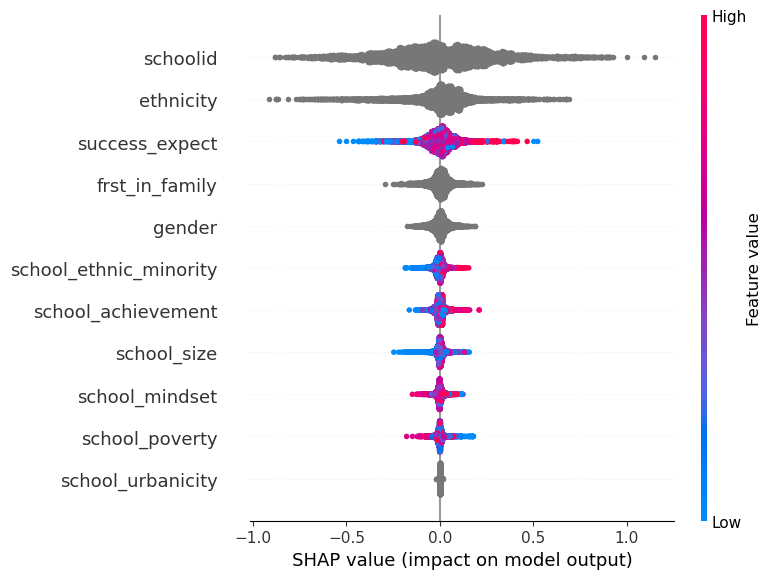

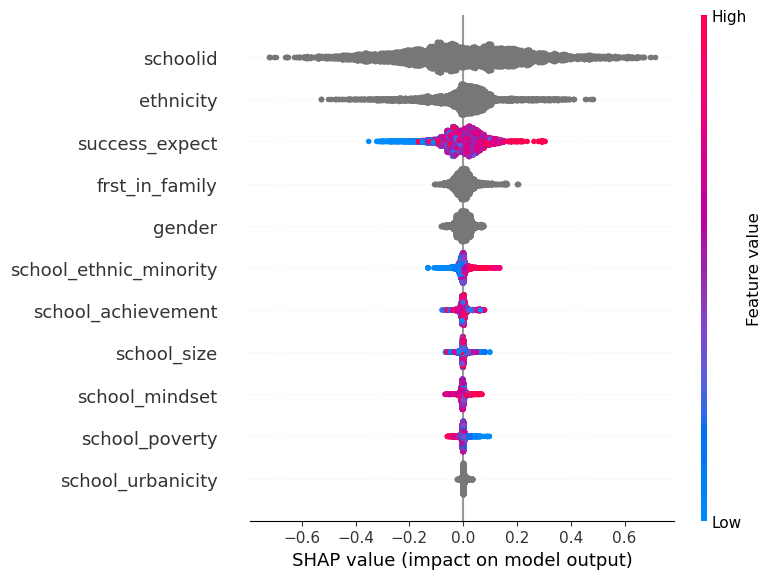

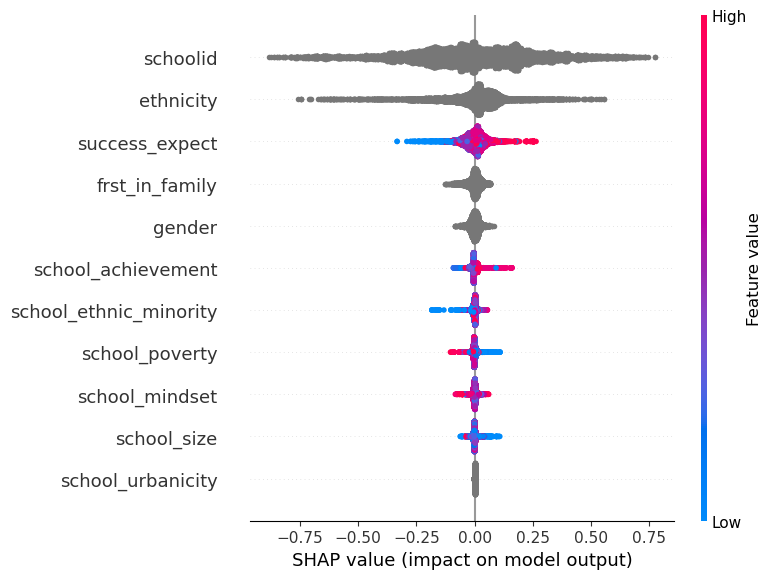

In [8]:
from shap import TreeExplainer, summary_plot

shap_values_rlearner = rlearner_explainer.shap_values(
    X=df[feature_columns], shap_explainer_factory=TreeExplainer
)
summary_plot(shap_values_rlearner[0], features=df[feature_columns])

shap_values_tlearner = tlearner_explainer.shap_values(
    X=df[feature_columns], shap_explainer_factory=TreeExplainer
)
summary_plot(shap_values_tlearner[0], features=df[feature_columns])

shap_values_rlearner_from_estimates = rlearner_explainer_from_estimates.shap_values(
    X=df[feature_columns], shap_explainer_factory=TreeExplainer
)
summary_plot(shap_values_rlearner_from_estimates[0], features=df[feature_columns])

In these SHAP summary plots, the color and orientation of the plotted values help us to understand
their impact on model predictions.

Each dot in the plot represents a single instance of the given feature present in the data set.
The x-axis displays the Shapley value, signifying the strength and directionality of the
feature's impact. The y-axis displays a subset of the features in the model.

The Shapley value, exhibited on the horizontal axis, is oriented such that values on the
right of the center line (0 mark) contribute to a positive shift in the predicted outcome,
while those on the left indicate a negative impact.

The color coding implemented in these plots is straightforward: red implies a high feature value,
while blue denotes a low feature value. This color scheme assists in identifying whether
high or low values of a certain feature influence the model's output positively or negatively.
The categorical variables are colored in grey.

For more guidelines on how to interpret such SHAP plots please see the [SHAP documentation](https://github.com/shap/shap).

Note that the method <a href="../../api_documentation/#metalearners.explainer.Explainer.shap_values"><code>shap_values</code></a> returns a list of length $n_{variats} - 1$ that indicates the SHAP values for
each variant against control.

### Further comments

* In the scenario where the model has a unique treatment model for each variant and the used
  base model does not compute ``feature_importances_``, the `Explainer`
  object will raise an error when calling <a href="../../api_documentation/#metalearners.explainer.Explainer.feature_importances"><code>feature_importances</code></a>.
  In that case, it is required to retrain a model which computes ``feature_importances_``
  by passing ``X``, ``cate_estimates`` and a compatible ``cate_model_factory`` to <a href="../../api_documentation/#metalearners.metalearner.MetaLearner.explainer"><code>MetaLearner.explainer</code></a>.